## Dependencies

In [1]:
import glob
import warnings
from tensorflow.keras import Model, optimizers
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Concatenate, Add, Average
from googleqa_utilityscript import *
from transformers import BertConfig, BertTokenizer, TFBertModel


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## Load data

In [2]:
BERT_PATH = '/kaggle/input/bert-base-uncased-huggingface/bert-base-uncased/bert-base-uncased-tf_model.h5'
VOCAB_PATH = '/kaggle/input/bert-base-uncased-huggingface/bert-base-uncased/bert-base-uncased-vocab.txt'
CONF_PATH = '/kaggle/input/bert-base-uncased-huggingface/bert-base-uncased/bert-base-uncased-config.json'

k_fold = pd.read_csv('/kaggle/input/googleqa-mldataset/5-fold.csv')
N_FOLDS = 3

print('Samples: %s' % len(k_fold))
display(k_fold.head())

Samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train


In [3]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

# Pre-process data

In [4]:
text_features = ['question_title', 'question_body', 'answer']
text_features_question = ['question_title', 'question_body']
text_features_answer = ['question_title', 'answer']

# Model parameters

In [5]:
EPOCHS = 6
BATCH_SIZE = 6
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
N_CLASS_QUESTION = len(question_target_cols)
N_CLASS_ANSWER = len(answer_target_cols)
ES_PATIENCE = 1
MAX_SEQUENCE_LENGTH = 512
MAX_LENGTH_TITLE = 30
MAX_LENGTH_QUESTION = 479
MAX_LENGTH_ANSWER = 479
STEP_SIZE = len(k_fold[k_fold['fold_1'] == 'train']) // BATCH_SIZE
TRAIN_STEPS = STEP_SIZE * EPOCHS
WARMUP_STEPS = TRAIN_STEPS * 0.2

# Model

In [6]:
bert_config = BertConfig.from_pretrained(CONF_PATH)
bert_config.output_hidden_states=False

def model_fn():
    input_word_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_question')
    input_masks_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_question')
    segment_ids_question = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_question')

    input_word_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids_answer')
    input_masks_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks_answer')
    segment_ids_answer = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids_answer')

    bert_model = TFBertModel.from_pretrained(BERT_PATH, config=bert_config)
    sequence_output_question, pooled_output_question = bert_model([input_word_ids_question, input_masks_question, segment_ids_question])
    sequence_output_answer, pooled_output_answer = bert_model([input_word_ids_answer, input_masks_answer, segment_ids_answer])
    
    x_question = GlobalAveragePooling1D()(sequence_output_question)
    x_question = Dropout(0.2)(x_question)
    output_question = Dense(N_CLASS_QUESTION, kernel_initializer='glorot_uniform', activation="sigmoid", name="outputquestion")(x_question)
    
    x_answer = GlobalAveragePooling1D()(sequence_output_answer)
    x_answer = Dropout(0.2)(x_answer)
    output_answer = Dense(N_CLASS_ANSWER, kernel_initializer='glorot_uniform', activation="sigmoid", name="output_answer")(x_answer)
    
    output = Concatenate()([output_question, output_answer])

    model = Model(inputs=[input_word_ids_question, input_masks_question, segment_ids_question, 
                          input_word_ids_answer, input_masks_answer, segment_ids_answer], outputs=output)

    return model

# Train model

In [7]:
import re

class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Applys a warmup schedule on a given learning rate decay schedule."""

    def __init__(self, initial_learning_rate, decay_schedule_fn, warmup_steps, power=1.0, name=None):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.power = power
        self.decay_schedule_fn = decay_schedule_fn
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmUp") as name:
            # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
            # learning rate will be `global_step/num_warmup_steps * init_lr`.
            global_step_float = tf.cast(step, tf.float32)
            warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
            warmup_percent_done = global_step_float / warmup_steps_float
            warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
            return tf.cond(
                global_step_float < warmup_steps_float,
                lambda: warmup_learning_rate,
                lambda: self.decay_schedule_fn(step),
                name=name,
            )

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_schedule_fn": self.decay_schedule_fn,
            "warmup_steps": self.warmup_steps,
            "power": self.power,
            "name": self.name,
        }



def create_optimizer(init_lr, num_train_steps, num_warmup_steps):
    """Creates an optimizer with learning rate schedule."""
    # Implements linear decay of the learning rate.
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
        initial_learning_rate=init_lr, decay_steps=num_train_steps, end_learning_rate=0.0
    )
    if num_warmup_steps:
        learning_rate_fn = WarmUp(
            initial_learning_rate=init_lr, decay_schedule_fn=learning_rate_fn, warmup_steps=num_warmup_steps
        )
    optimizer = AdamWeightDecay(
        learning_rate=learning_rate_fn,
        weight_decay_rate=0.01,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-6,
        exclude_from_weight_decay=["layer_norm", "bias"],
    )
    return optimizer



class AdamWeightDecay(tf.keras.optimizers.Adam):
    """Adam enables L2 weight decay and clip_by_global_norm on gradients.

  Just adding the square of the weights to the loss function is *not* the
  correct way of using L2 regularization/weight decay with Adam, since that will
  interact with the m and v parameters in strange ways.

  Instead we want ot decay the weights in a manner that doesn't interact with
  the m/v parameters. This is equivalent to adding the square of the weights to
  the loss with plain (non-momentum) SGD.
  """

    def __init__(
        self,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False,
        weight_decay_rate=0.0,
        include_in_weight_decay=None,
        exclude_from_weight_decay=None,
        name="AdamWeightDecay",
        **kwargs
    ):
        super().__init__(learning_rate, beta_1, beta_2, epsilon, amsgrad, name, **kwargs)
        self.weight_decay_rate = weight_decay_rate
        self._include_in_weight_decay = include_in_weight_decay
        self._exclude_from_weight_decay = exclude_from_weight_decay

    @classmethod
    def from_config(cls, config):
        """Creates an optimizer from its config with WarmUp custom object."""
        custom_objects = {"WarmUp": WarmUp}
        return super().from_config(config, custom_objects=custom_objects)


    def _prepare_local(self, var_device, var_dtype, apply_state):
        super()._prepare_local(var_device, var_dtype, apply_state)
        apply_state["weight_decay_rate"] = tf.constant(self.weight_decay_rate, name="adam_weight_decay_rate")

    def _decay_weights_op(self, var, learning_rate, apply_state):
        do_decay = self._do_use_weight_decay(var.name)
        if do_decay:
            return var.assign_sub(
                learning_rate * var * apply_state["weight_decay_rate"], use_locking=self._use_locking
            )
        return tf.no_op()

#     def apply_gradients(self, grads_and_vars, clip_norm, name=None):
#         grads, tvars = list(zip(*grads_and_vars))
#         (grads, _) = tf.clip_by_global_norm(grads, clip_norm=clip_norm)
#         return super().apply_gradients(zip(grads, tvars))
    def apply_gradients(self, grads_and_vars, name=None):
        return super().apply_gradients(grads_and_vars)


    def _get_lr(self, var_device, var_dtype, apply_state):
        """Retrieves the learning rate with the given state."""
        if apply_state is None:
            return self._decayed_lr_t[var_dtype], {}

        apply_state = apply_state or {}
        coefficients = apply_state.get((var_device, var_dtype))
        if coefficients is None:
            coefficients = self._fallback_apply_state(var_device, var_dtype)
            apply_state[(var_device, var_dtype)] = coefficients

        return coefficients["lr_t"], dict(apply_state=apply_state)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        lr_t, kwargs = self._get_lr(var.device, var.dtype.base_dtype, apply_state)
        decay = self._decay_weights_op(var, lr_t, apply_state)
        with tf.control_dependencies([decay]):
            return super()._resource_apply_dense(grad, var, **kwargs)

    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
        lr_t, kwargs = self._get_lr(var.device, var.dtype.base_dtype, apply_state)
        decay = self._decay_weights_op(var, lr_t, apply_state)
        with tf.control_dependencies([decay]):
            return super()._resource_apply_sparse(grad, var, indices, **kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({"weight_decay_rate": self.weight_decay_rate})
        return config


    def _do_use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if self.weight_decay_rate == 0:
            return False

        if self._include_in_weight_decay:
            for r in self._include_in_weight_decay:
                if re.search(r, param_name) is not None:
                    return True

        if self._exclude_from_weight_decay:
            for r in self._exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [8]:
tokenizer = BertTokenizer.from_pretrained(VOCAB_PATH, do_lower_case=True)

history_list = []
metric_list = []
category_metric_list = []
target_cols_preds = [col+'_pred' for col in target_cols]

for n_fold in range(N_FOLDS):
    ### Data
    train = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation']
    
    ### Create features
    # Train features
    X_train = compute_input_arays_2(train, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                    MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                + compute_input_arays_2(train, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                        MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
    Y_train = train[target_cols].values

    # Validation features
    X_valid = compute_input_arays_2(validation, text_features_question, tokenizer, MAX_SEQUENCE_LENGTH, 
                                    MAX_LENGTH_TITLE, MAX_LENGTH_QUESTION, ignore_first_sep=False)\
                + compute_input_arays_2(validation, text_features_answer, tokenizer, MAX_SEQUENCE_LENGTH, 
                                        MAX_LENGTH_TITLE, MAX_LENGTH_ANSWER, ignore_first_sep=False)
    Y_valid = validation[target_cols].values

    # Train model
    model_path = '/kaggle/working/model_fold_%d' % (n_fold+1)
    spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                           validation_data=(X_valid, Y_valid), 
                                           model_path=model_path, 
                                           monitor='val_loss', mode='min', 
                                           patience=ES_PATIENCE, checkpoint=True)

    callback_list = [spearmanCallback]
    optimizer = create_optimizer(init_lr=LEARNING_RATE, num_train_steps=TRAIN_STEPS, num_warmup_steps=WARMUP_STEPS)
    model = model_fn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid), 
                        callbacks=callback_list, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights('/kaggle/working/model_fold_%d_last_epoch.h5' % (n_fold+1))
    
    ### Evaluation - Label metrics
    model.load_weights(model_path+'.h5')
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_valid)
    metric_list.append(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))
    
    ### Evaluation - Category metrics
    for col in target_cols_preds:
        train[col] = 0
        validation[col] = 0

    train[target_cols_preds] = preds_train
    validation[target_cols_preds] = preds_val
    category_metric_list.append(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

Train on 4864 samples, validate on 1215 samples
Epoch 1/6
spearman-rho: 0.3760 val_spearman-rho: 0.3460
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 1026s - loss: 0.4333 - val_loss: 0.3740
Epoch 2/6
spearman-rho: 0.4598 val_spearman-rho: 0.3986
Saved model weights at "/kaggle/working/model_fold_1.h5"
4864/4864 - 970s - loss: 0.3737 - val_loss: 0.3661
Epoch 3/6
spearman-rho: 0.5092 val_spearman-rho: 0.4075
Epoch 00002: early stopping
4864/4864 - 968s - loss: 0.3561 - val_loss: 0.3662
Train on 4864 samples, validate on 1215 samples
Epoch 1/6
spearman-rho: 0.3913 val_spearman-rho: 0.3549
Saved model weights at "/kaggle/working/model_fold_2.h5"
4864/4864 - 1026s - loss: 0.4298 - val_loss: 0.3764
Epoch 2/6
spearman-rho: 0.4617 val_spearman-rho: 0.3916
Saved model weights at "/kaggle/working/model_fold_2.h5"
4864/4864 - 970s - loss: 0.3722 - val_loss: 0.3686
Epoch 3/6
spearman-rho: 0.5102 val_spearman-rho: 0.3980
Saved model weights at "/kaggle/working/model_fold_2.h5

## Model loss graph

Fold: 0


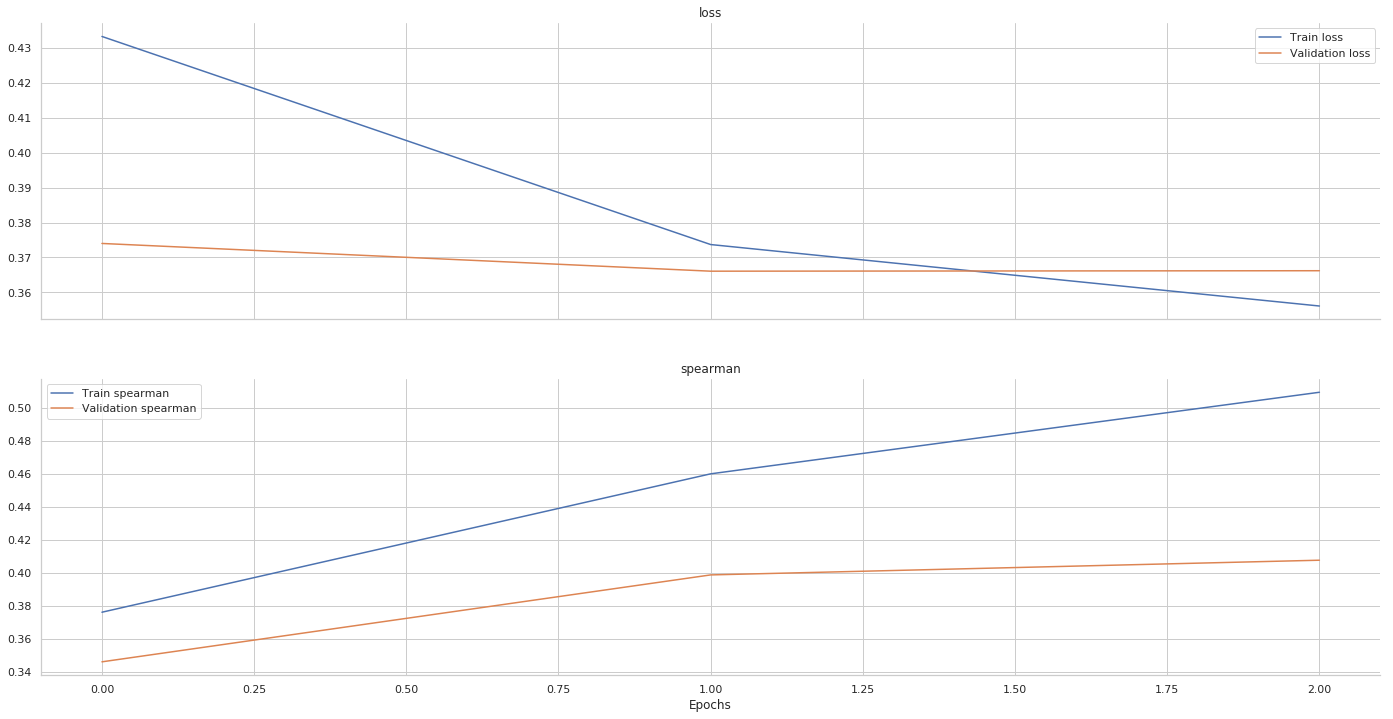

Fold: 1


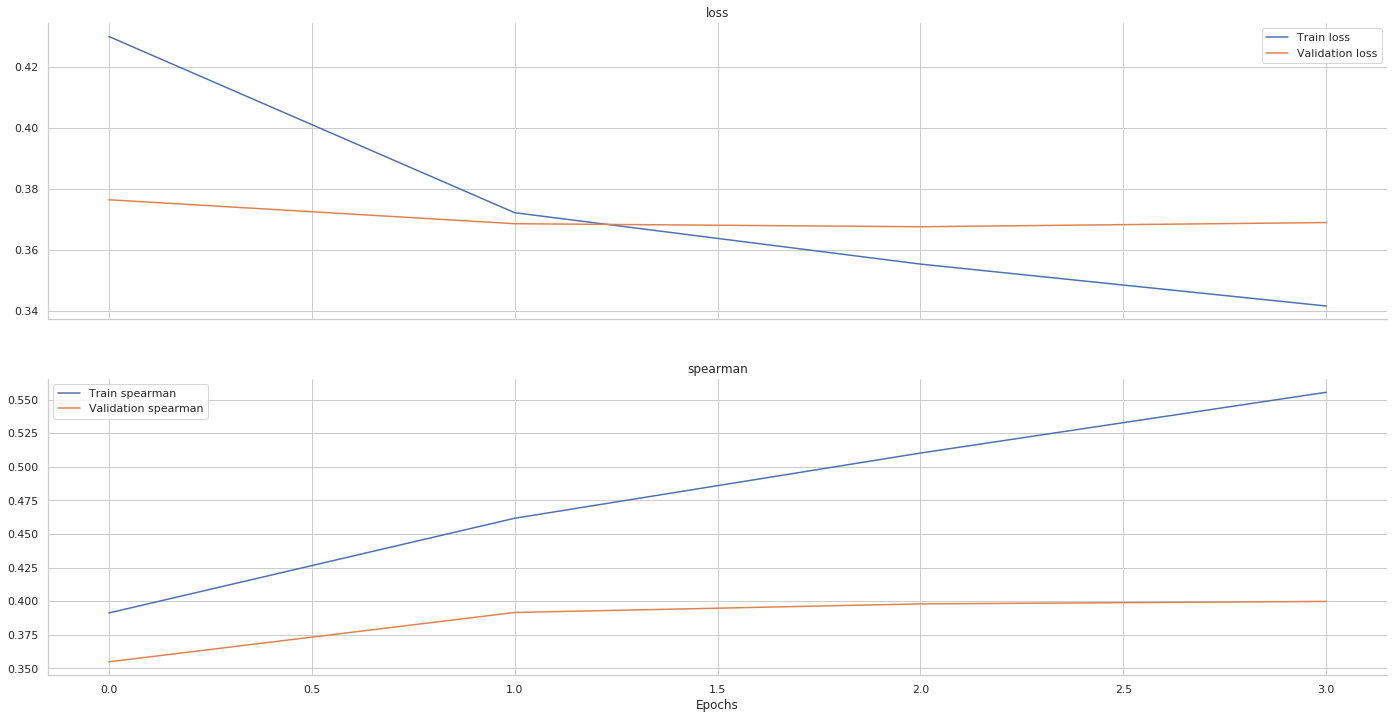

Fold: 2


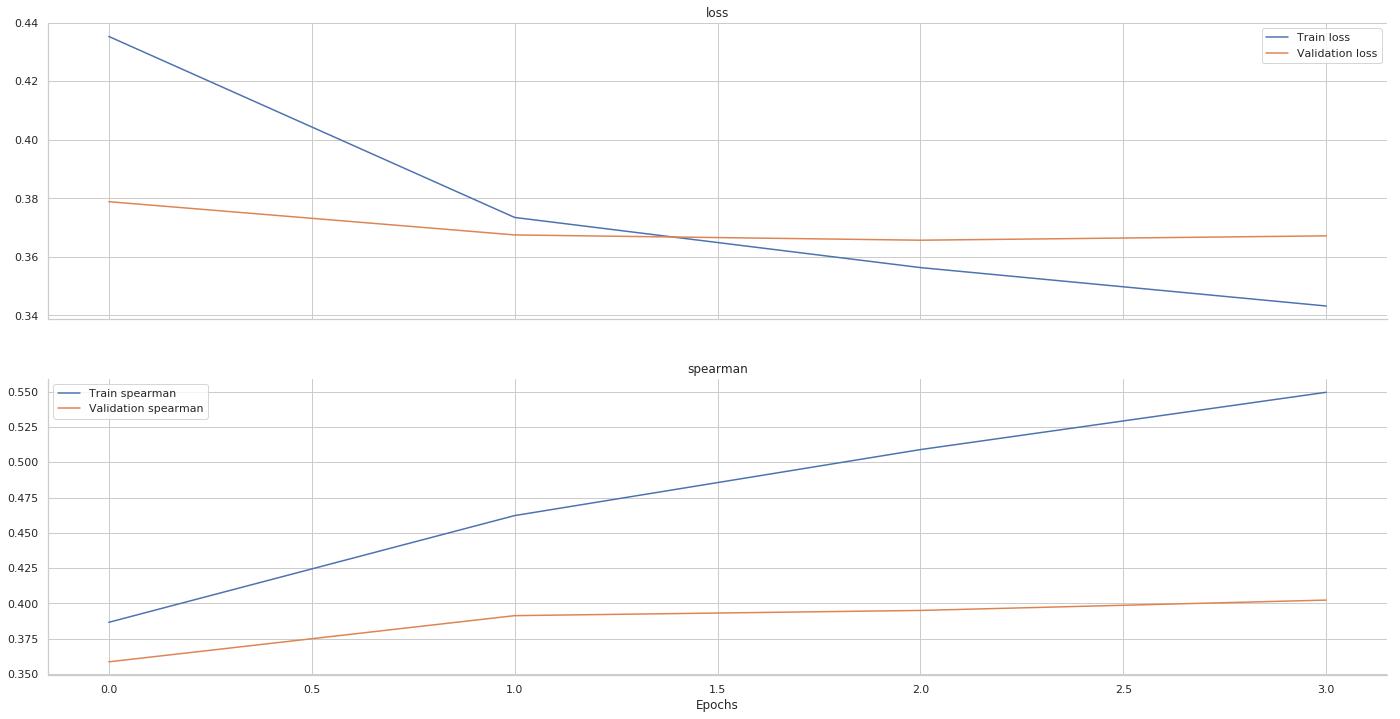

In [9]:
for n_fold in range(N_FOLDS):
    print('Fold: %d' % n_fold)
    sns.set(style="whitegrid")
    plot_metrics(history_list[n_fold], metric_list=['loss', 'spearman'])

# Evaluation

In [10]:
metrics_df = metric_list[0][['Label', 'Train', 'Validation']].copy()
metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    metrics_df_idx = metric_list[n_fold][['Train', 'Validation']].copy()
    metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    metrics_df = pd.concat([metrics_df, metrics_df_idx], axis=1)

metrics_df['Train'] = 0
metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    metrics_df['Train'] += metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    metrics_df['Validation'] += metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS

metrics_df['Var'] = metrics_df['Train'] - metrics_df['Validation']
display(metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,Averaged,0.46,0.399,0.51,0.398,0.509,0.395,0.493,0.397333,0.0956667
1,Question averaged,0.478,0.43,0.523,0.427,0.522,0.42,0.507667,0.425667,0.082
2,Answer averaged,0.418,0.325,0.481,0.331,0.48,0.337,0.459667,0.331,0.128667
3,question_asker_intent_understanding,0.414,0.4,0.476,0.386,0.48,0.327,0.456667,0.371,0.0856667
4,question_body_critical,0.696,0.652,0.727,0.681,0.745,0.646,0.722667,0.659667,0.063
5,question_conversational,0.453,0.428,0.475,0.408,0.47,0.425,0.466,0.420333,0.0456667
6,question_expect_short_answer,0.352,0.343,0.503,0.258,0.486,0.269,0.447,0.29,0.157
7,question_fact_seeking,0.477,0.393,0.566,0.362,0.558,0.384,0.533667,0.379667,0.154
8,question_has_commonly_accepted_answer,0.516,0.443,0.583,0.434,0.596,0.415,0.565,0.430667,0.134333
9,question_interestingness_others,0.376,0.278,0.429,0.28,0.428,0.286,0.411,0.281333,0.129667


## By category

In [11]:
category_metrics_df = category_metric_list[0][['Label', 'Train', 'Validation']].copy()
category_metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    category_metrics_df_idx = category_metric_list[n_fold][['Train', 'Validation']].copy()
    category_metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    category_metrics_df = pd.concat([category_metrics_df, category_metrics_df_idx], axis=1)
    
category_metrics_df['Train'] = 0
category_metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    category_metrics_df['Train'] += category_metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    category_metrics_df['Validation'] += category_metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS
    
category_metrics_df['Var'] = category_metrics_df['Train'] - category_metrics_df['Validation']
display(category_metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train,Validation,Var
0,LIFE_ARTS,0.489,0.411,0.55,0.4,0.547,0.442,0.528667,0.417667,0.111
1,SCIENCE,0.473,0.407,0.548,0.38,0.543,0.398,0.521333,0.395,0.126333
2,CULTURE,0.479,0.417,0.531,0.402,0.477,0.355,0.495667,0.391333,0.104333
3,STACKOVERFLOW,0.334,0.278,0.396,0.292,0.528,0.389,0.419333,0.319667,0.0996667
4,TECHNOLOGY,0.427,0.355,0.479,0.369,0.397,0.269,0.434333,0.331,0.103333
